In [2]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import sys
sys.path.append('../../module/')

from keras2.models import Model
from keras2.layers import concatenate, Dense, Input, Flatten
from keras2.optimizers import Adam
import csv
from util import *
import gym2
from rl2.agents import selfDDPGAgent, selfDDPGAgent2
from rl2.memory import SequentialMemory

Using TensorFlow backend.
Using TensorFlow backend.


In [3]:
env = gym2.make('Pendulum-v2')

In [5]:
def critic_net(a_shape , s_shape):
    action_input = Input(a_shape)
    observation_input = Input(shape=(1,)+s_shape)
    flattened_observation = Flatten()(observation_input)
    x = concatenate([action_input, flattened_observation])
    x = Dense(16, activation="relu")(x)
    x = Dense(16, activation="relu")(x)
    x = Dense(1, activation="linear")(x)
    critic = Model(inputs=[action_input, observation_input], outputs=x)
    return (critic, action_input)

def branch_actor(a_shape, s_shape):
    action_input = Input(shape=(1,)+s_shape)
    x = Flatten()(action_input) # 実質的なinput layer
    
    x1 = Dense(8, activation="relu")(x)
    x1 = Dense(8, activation="relu")(x1)
    x1 = Dense(1, activation="multiple_tanh")(x1) # action signal
    
    x2 = Dense(8, activation="relu")(x)
    x2 = Dense(8, activation="relu")(x2)
    x2 = Dense(1, activation="tau_output")(x2) # tau
    
    output = concatenate([x1, x2])
    actor = Model(inputs=action_input, outputs=output)
    return actor


def agent2(a_shape, s_shape):
    actor = branch_actor(a_shape, s_shape)
    critic, critic_action_input = critic_net(a_shape, s_shape)
    memory = SequentialMemory(limit = 50000, window_length = 1)
    agent = selfDDPGAgent2(
        a_shape[0],
        actor,
        critic,
        critic_action_input,
        memory,
        mb_noise=False,
        coef_u=.01,
        coef_tau=.001,
        action_clipper=[-10., 10.],
        tau_clipper=[0.001, 1.],
        params_logging=False,
        gradient_logging=False,
        batch_size=128,
    )
    return agent

In [6]:
#learning   
l = .1
step = 1000000  # num of interval
episode_step = step
a = agent2((2,), (2,))
actor_optimizer, critic_optimizer = Adam(lr=100., clipnorm=1.), Adam(lr=0.001, clipnorm=1.) # actorの方は何でもいい
optimizer = [actor_optimizer, critic_optimizer]
a.compile(optimizer=optimizer, metrics=["mse"], action_lr=0.0001, tau_lr=0.001)

b = agent2((2,), (2,))
b.compile(optimizer=optimizer, metrics=["mse"], action_lr=0.0001, tau_lr=0.001)

In [50]:
l = 1.
def value_function(state, agent, env, gamma=.99, step_limit=1000):
    env.reset()
    env.set_state(state)
    value = 0
    
    for step in range(step_limit):
        reward = 0
        x = env.state
        a_agent, tau = agent.forward(x)
        
        action_repetition = int(np.ceil(20 * tau))  # minimum natural number which makes `dt` smaller than 0.05
        dt = tau / action_repetition
        for p in range(action_repetition):
            _,r,_,_ = env.step(np.array([a_agent]), dt, tau)
            reward += r
        reward *= dt
        reward += - tau * 0.01 * a_agent**2 + l * tau
        
        value += pow(gamma, step) * reward
 
    return value

In [51]:
a.actor.load_weights('./saved_agent/sample_02.h5')
state = np.array([3,3])
value_function(state, a, env)

-10.252825420023507

In [55]:
%%time
a.actor.load_weights('./saved_agent/sample_02.h5')

s1 = np.linspace(-np.pi, np.pi, 100)
s2 = np.linspace(-2*np.pi, 2*np.pi, 100)
S1, S2 = np.meshgrid(s1, s2)

values_init = []
values_rl = []
i = 0

for state in zip(S1.flatten(), S2.flatten()):
    print(f'{int(i*100/S1.shape[0]**2)}%\r', end='')
    i += 1
    state = np.array(state)
    values_init.append(value_function(state, a, env))
    
values_init = np.array(values_init).reshape(S1.shape)

CPU times: user 2h 37min 33s, sys: 10min 3s, total: 2h 47min 37s
Wall time: 2h 52min 15s


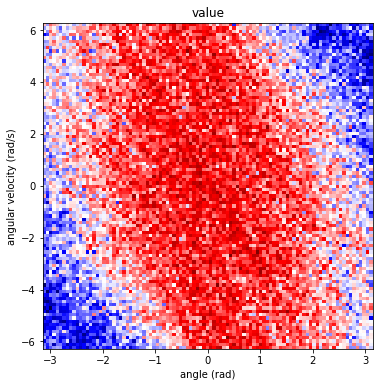

In [60]:
fig = plt.figure(figsize=(13,6))
ax1 = fig.add_subplot(121)
ax1.set_xlabel('angle (rad)')
ax1.set_ylabel('angular velocity (rad/s)')
ax1.set_title('value')

ax1.pcolormesh(S1, S2, values_init, cmap='seismic')

In [64]:
np.max(values_init), np.mean(values_init)

(-2.6084348469430796, -7.573157532090408)

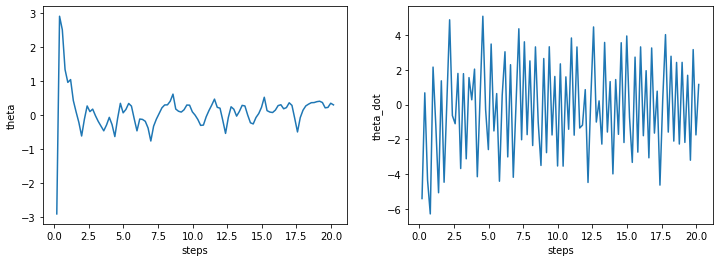

In [45]:
%matplotlib inline

a.training = False
env.reset()
env.set_state(np.array([-2.9, -5.4]))
states = []
time_limit = 20
time_log = []
taus = []
acc_time = 0
episode_reward = 0
while True:
    reward = 0
    x = env.state
    states.append(x)
    a_agent, tau = a.forward(x)
    taus.append(tau)
    acc_time += tau
    time_log.append(acc_time)
    action_repetition = int(np.ceil(200 * tau))  # minimum natural number which makes `dt` smaller than 0.005
    dt = tau / action_repetition
    # print(tau, dt, action_repetition)
    for p in range(action_repetition):
        _,_,r,_ = env.step(np.array([a_agent]), dt, tau)
        reward += r
    reward *= dt
    reward += - 0.01 * a_agent**2 + l * tau
    episode_reward += reward
    if acc_time > time_limit:
        break
states = np.array(states)

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.xlabel('steps')
plt.ylabel('theta')
plt.plot(time_log, states[:,0])
plt.subplot(1,2,2)
plt.xlabel('steps')
plt.ylabel('theta_dot')
plt.plot(time_log, states[:,1])
plt.show()

In [53]:
%%time

# どのくらいのstep数で切るのが妥当？
# experiment

# 近い二つの状態のパスを比べる
l = 1.

view_path = True
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

# step wise evaluation

start_point = np.array([[.0, .0], [2.0, -1.0], [-2.0, 1.0]])
step_limit = 5000
n_episodes = len(start_point)
gamma = .99
average_reward = 0
rewardss = []


for ep in range(n_episodes):
    state_log = []
    rewards = []
    env.reset()
    env.set_state(start_point[ep])
    episode_reward = 0
    for steps in range(step_limit):
        reward = 0
        x = env.state
        a_agent, tau = a.forward(x)
        state_log.append(x)
        action_repetition = int(np.ceil(20 * tau))  # minimum natural number which makes `dt` smaller than 0.005
        dt = tau/action_repetition
        for p in range(action_repetition):
            _,r,_,_ = env.step(np.array([a_agent]), dt, tau)
            reward += r
        reward *= dt
        reward += - tau * 0.01 * a_agent**2 + l * tau # step reward
        rewards.append(reward)
        #if steps < 5000:
            #print(steps, reward, pow(gamma, steps) * reward)

        episode_reward += pow(gamma, steps) * reward
    print(episode_reward)
    rewardss.append(rewards)

-5.731220729027653
-8.247469743623615
-6.94047495138777
CPU times: user 12.9 s, sys: 844 ms, total: 13.7 s
Wall time: 13.2 s


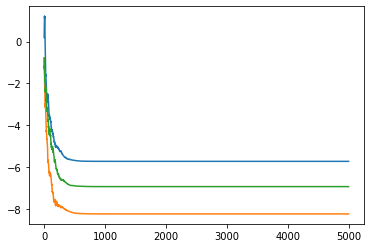

In [54]:
for rewards in rewardss:
    eps = 0
    discounts = []
    for i,r in enumerate(rewards):
        eps += pow(.99,i) * r
        discounts.append(eps)
    plt.plot(discounts)
    

In [15]:
with open('./csv/value_true1.csv', 'r') as f:
    reader = csv.reader(f)
    vs = np.array([r for r in reader]).astype('float')
values_rl = vs.reshape(100,100)

In [58]:
with open('./csv/value_init.csv', 'w') as f:
    writer = csv.writer(f)
    writer.writerow(values_init.flatten())